# Forcasting model for Covid-19 data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets

from sklearn import metrics
from sklearn import preprocessing
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import LassoLars

from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from scipy.special import softmax

# Reading Covid dataset

The analysis will be based on the Covid-19 data provided by [Our World in Data](https://github.com/owid).

In [2]:
data_url = (
    "https://raw.githubusercontent.com/"
    "owid/covid-19-data/master/public/data/owid-covid-data.csv"
)
raw_df = pd.read_csv(data_url)
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68533 entries, 0 to 68532
Data columns (total 59 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   iso_code                               68533 non-null  object 
 1   continent                              65106 non-null  object 
 2   location                               68533 non-null  object 
 3   date                                   68533 non-null  object 
 4   total_cases                            67749 non-null  float64
 5   new_cases                              67747 non-null  float64
 6   new_cases_smoothed                     66746 non-null  float64
 7   total_deaths                           58846 non-null  float64
 8   new_deaths                             59004 non-null  float64
 9   new_deaths_smoothed                    66746 non-null  float64
 10  total_cases_per_million                67377 non-null  float64
 11  ne

Pre-processing dataset:

- Renormalize date to a `datetime` object.
- Reduce the number of columns
- Set date as index
- Drop `NaN`'s
- Fix types for columns

In [3]:
total_df = raw_df.copy()
total_df.date = pd.to_datetime(total_df.date)
total_df = total_df[
    [
        "location",
        "date",
        "total_cases",
        "new_cases",
        "new_cases_smoothed",
        "total_deaths",
        "new_deaths",
        "new_deaths_smoothed",
        "icu_patients",
    ]
]
total_df = total_df.set_index("date")
total_df = total_df.dropna()
total_df = total_df.astype(
    {
        "total_cases": int,
        "new_cases": int,
        "total_deaths": int,
        "new_deaths": int,
        "icu_patients": int,
    }
)
total_df.head()

,location,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,icu_patients
date,,,,,,,,
2020-04-01,Austria,10711,531,731.857,146,18,16.571,215
2020-04-02,Austria,11129,418,602.857,158,12,15.571,219
2020-04-03,Austria,11524,395,552.429,168,10,15.714,245
2020-04-04,Austria,11781,257,501.429,186,18,16.857,245
2020-04-05,Austria,12051,270,466.143,204,18,16.857,244


## Data exploration



In [4]:
@widgets.interact(
    country=total_df.location.unique(),
    column=[c for c in total_df.columns if c not in ["location", "date"]],
)
def plot_evolution(country, column):
    total_df.loc[total_df.location == country].plot(
        y=column,
        figsize=(15, 5),
        xlim=(pd.Timestamp("2020-01-01"), pd.Timestamp("2021-02-02")),
    )

interactive(children=(Dropdown(description='country', options=('Austria', 'Belgium', 'Bulgaria', 'Canada', 'Cy…

In [5]:
@widgets.interact(
    country=widgets.Dropdown(options=total_df.location.unique()),
)
def compare_newCases_icu_deaths(country):
    (
        total_df.loc[total_df.location == country]
        .apply(
            lambda x: x / x.max()
            if x.name in {"new_cases_smoothed", "new_deaths_smoothed", "icu_patients"}
            else x
        )
        .plot(
            y=["new_cases_smoothed", "icu_patients", "new_deaths_smoothed"],
            figsize=(15, 5),
            xlim=(pd.Timestamp("2020-01-01"), pd.Timestamp("2021-02-02")),
        )
    )

interactive(children=(Dropdown(description='country', options=('Austria', 'Belgium', 'Bulgaria', 'Canada', 'Cy…

## Model description

```
+-----------+     +---------------+     +--------+
| New cases | ==> | New ICU cases | ==> | Deaths |
+-----------+     +---------------+     +--------+
```

In the following, we want to develop a model to forecast the number of ICUs based on the number of new cases. We can clearly say that a fraction of new cases will end up needing intensive care. However, we also know that there are a fraction of patients being released. Rather than using mathematical models in epidemiology, we develop a data-driven model to forecast the evolution of the number of ICU patients. 

We start by examining which model we should use even before looking at feature engineering. Our intuition suggests using a linear regression model (or any linear model). We first create a dataset with some features and focus on picking the best performing model before using feature engineering to optimize it.

In [6]:
icu_patients = total_df.loc[
    total_df.location == "Germany",
    ["icu_patients", "new_cases", "new_cases_smoothed"],
]
icu_patients["icu_patients_yesterday"] = icu_patients["icu_patients"].shift(1)
icu_patients = icu_patients.dropna()
icu_patients

,icu_patients,new_cases,new_cases_smoothed,icu_patients_yesterday
date,,,,
2020-03-21,308,2365,2518.286,200.0
2020-03-22,364,2660,2725.429,308.0
2020-03-23,451,4183,3112.000,364.0
2020-03-24,616,3930,3389.857,451.0
2020-03-25,789,4337,3570.857,616.0
...,...,...,...,...
2021-01-30,4342,17518,12460.000,4367.0
2021-01-31,4337,748,11127.143,4342.0
2021-02-01,4313,6668,11095.857,4337.0


### Training and tests set for model selection

In [7]:
X_train = icu_patients.loc[:"2021"].drop(["icu_patients"], axis=1)
y_train = icu_patients.loc[:"2021", "icu_patients"]

X_test = icu_patients.loc["2021"].drop(["icu_patients"], axis=1)
y_test = icu_patients.loc["2021":, "icu_patients"]

### Validate models

In [8]:
models = [
    ("LR", LinearRegression()),
    ("RF", RandomForestRegressor()),
    ("Ridge", Ridge()),
    ("Lasso", Lasso()),
    ("EN", ElasticNet()),
    ("LL", LassoLars()),
    ("KN", KNeighborsRegressor()),
]

results = []
names = []

for name, model in models:
    tscv = TimeSeriesSplit(n_splits=2)
    cv_results = cross_val_score(model, X_train, y_train, cv=tscv, scoring="r2")
    results.append(cv_results)
    names.append(name)
    print(f"{name:>5}: {cv_results.mean():12.2f} ({cv_results.std():.2f})")

   LR:         0.87 (0.05)
   RF:        -0.01 (0.75)
Ridge:         0.87 (0.05)
Lasso:         0.87 (0.05)
   EN:         0.87 (0.05)
   LL:         0.89 (0.08)
   KN:        -3.87 (1.16)


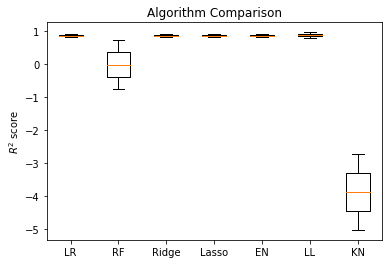

In [9]:
plt.boxplot(results, labels=names)
plt.ylabel("$R^2$ score")
plt.title("Algorithm Comparison");

Comparing the different algorithms, we see that the assumption that linear regression (or a linear model) might be okay holds.

We can now look at the prediction for 2021 and how each model performs precisely.

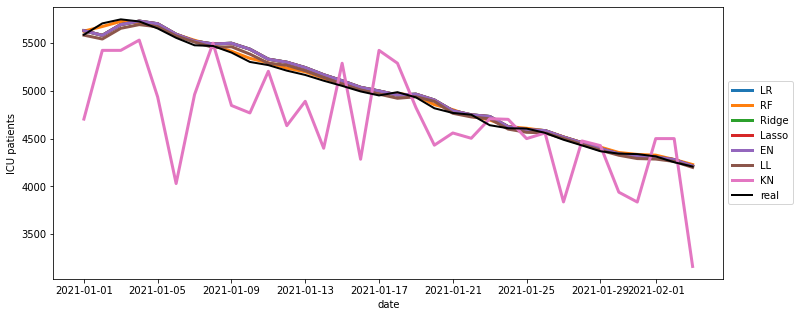

In [10]:
plt.figure(figsize=(12, 5))
for name, model in models:
    plt.plot(
        X_test.index,
        model.fit(X_train, y_train).predict(X_test),
        label=name,
        linewidth=3.0,
    )
plt.plot(y_test, color="k", label="real", linewidth=2.0)
plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.xlabel("date")
plt.ylabel("ICU patients");

We can see that the different models predict the same outcome for 2021 if we train on the data for 2020, and only KNeighborsRegressor seems to drop off. Nevertheless, we will use `LinearRegression` and examine which feature we need for the best performance.

Indeed, proper normalization might be more useful here, but we continue looking into determining the appropriate features to be used for the prediction.

### Feature engineering

For evaluating the performance for different features, we will have an overview of how the model performs for the beginning of 2021, and then we look at the $r^2$-score of each feature method. Let's define methods to plot the corresponding datasets.

In [53]:
def split_full_dataframe(df):
    """Splits full dataframe into two groups
  
    The whole dataframe `df` is split into two groups with two different dataframes.
    The first group consists of two dataframes until Jan 2021 with training
    data and target data. In contrast, the second group consists of two
    dataframes for validation with test data and corresponding real data.
    """
    X = df.loc[:"2021-01", :].drop("icu_patients", axis=1)
    y = df.loc[:"2021-01", :][["icu_patients"]]

    X_validate = df.loc["2021-01":, :].drop("icu_patients", axis=1)
    y_validate = df.loc["2021-01":, :][["icu_patients"]]

    return X, y, X_validate, y_validate

def train_model(X, y, n_splits, model):
    """Training model
    
    Runs `model.fit` using the training data `X` and target values `y`.
    The model fit is done using cross-validation with time series split
    `TimeSeriesSplit` of sklearn where the argument `n_splits` determines
    the maximum number of splits.
    """
    tscv = TimeSeriesSplit(n_splits=n_splits)
    score = []
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        score.append(model.score(X_test, y_test))

    return model, score

def model_performance_vis(df, n_splits, model):
    """Train model and visualize results
    
    Take dataframe `df` and split it, then train the model `model` using
    `n_splits`-splits for cross-validation. Afterwards use visulize the
    data with the left plot showing the predicted and the real number of ICU
    patients and the right showing the feature importance.
    """
    X, y, X_validate, y_validate = split_full_dataframe(df)
    model, score = train_model(X, y, n_splits, model)

    y_validate["icu_predicted"] = model.predict(X_validate)

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 4))

    y_validate.plot.line(
        y=["icu_patients", "icu_predicted"],
        ax=ax1,
        ylabel="ICU patients",
    )
    ax1.legend(["Real", "Predicted"])

    feature_values = softmax(np.abs(model.coef_[0]))
    sorted_indices = feature_values.argsort()
    feature_names = np.array(X.columns)

    ax2.barh(
        np.arange(len(feature_values)), feature_values[sorted_indices], align="center"
    )
    ax2.set_xlim(0, 1.0)
    ax2.set_xticks(np.linspace(0, 1.0, 6))
    ax2.set_xticklabels([f"{int(100 * f)} %" for f in np.linspace(0, 1.0, 6)])
    ax2.set_xlabel("Relative importance")
    ax2.set_yticks(range(len(feature_names)))
    ax2.set_yticklabels(feature_names[sorted_indices])
    fig.tight_layout()

def evaluate_feature_selection(
    feature_selection_method,
    full_df, 
    model=LinearRegression(),
):
    """Visualize feature selection interactively
    
    Function for creating two widgets, a dropdown with country selection
    and a slider with selecting number of cross-validation splits.
    """
    @widgets.interact(
        country=widgets.Dropdown(
            options=full_df.location.unique(),
            description="Country"
        ),
        n_splits=widgets.IntSlider(
            value=5,
            min=2,
            max=24,
            description="CV splits",
            orientation="horizontal",
        ),
    )
    def country_selection(country, n_splits):
        df = feature_selection_method(full_df[full_df.location == country])
        model_performance_vis(df, n_splits, model)

#### Method 1:

Features are `new_cases`

In [54]:
def method_1(df):
    """1: new cases"""
    return df.loc[:, ["icu_patients", "new_cases"]]

evaluate_feature_selection(method_1, total_df)

interactive(children=(Dropdown(description='Country', options=('Austria', 'Belgium', 'Bulgaria', 'Canada', 'Cy…

#### Method 2:

Features are `new_cases` and `new_cases_smoothed`

In [55]:
def method_2(df):
    """2: new cases + smoothed"""
    return df.loc[:, ["icu_patients", "new_cases", "new_cases_smoothed"]]

evaluate_feature_selection(method_2, total_df)

interactive(children=(Dropdown(description='Country', options=('Austria', 'Belgium', 'Bulgaria', 'Canada', 'Cy…

#### Method 3:

Features are `new_cases`, `new_cases_smoothed`, and `icu_-1d` (number of ICU patient of previous day)

In [56]:
def method_3(df):
    """3: new cases + smoothed + ICU (-1d)"""
    df = df.loc[:, ["icu_patients", "new_cases", "new_cases_smoothed"]]
    df["icu_-1d"] = df["icu_patients"].shift(1)
    df = df.dropna()
    return df

evaluate_feature_selection(method_3, total_df)

interactive(children=(Dropdown(description='Country', options=('Austria', 'Belgium', 'Bulgaria', 'Canada', 'Cy…

#### Method 4:

Features are `new_cases`, `new_cases_smoothed`, `icu_-1d` (number of ICU patient of previous day), and `icu_-1d_diff` (change of number of ICU patient of previous day).

In [57]:
def method_4(df):
    """4: new cases + smoothed + ICU (-1d) + ∆ICU(-1d)"""
    df = df.loc[:, ["icu_patients", "new_cases", "new_cases_smoothed"]]
    df["icu_-1d"] = df["icu_patients"].shift(1)
    df["icu_-1d_diff"] = df["icu_-1d"].diff()
    df = df.dropna()
    return df

evaluate_feature_selection(method_4, total_df)

interactive(children=(Dropdown(description='Country', options=('Austria', 'Belgium', 'Bulgaria', 'Canada', 'Cy…

#### Method 5:

Features are `new_cases`, `new_cases_smoothed`, `icu_-1d` (number of ICU patient of previous day), and `icu_-1d_diff` (change of number of ICU patient of previous day - **smoothed**).

In [58]:
def method_5(df):
    """5: new cases + smoothed new + ICU (-1d) + ∆ICU(-1d) smooth"""
    df = df.loc[:, ["icu_patients", "new_cases", "new_cases_smoothed"]]
    df["icu_-1d"] = df["icu_patients"].shift(1)
    df["icu_-1d_diff"] = df["icu_-1d"].diff().rolling(7, center=True).mean()
    df = df.dropna()
    return df

evaluate_feature_selection(method_5, total_df)

interactive(children=(Dropdown(description='Country', options=('Austria', 'Belgium', 'Bulgaria', 'Canada', 'Cy…

#### Method 6:

Features are `new_cases_smoothed`, `icu_-1d` (number of ICU patients from day before), and `icu_-1d_diff` (change of number of ICU patient of previous day - **smoothed**).

In [59]:
def method_6(df):
    """6: smoothed new + ICU(-1d) + ∆ICU(-1d)"""
    df = df.loc[:, ["icu_patients", "new_cases_smoothed"]]
    df["icu_-1d"] = df["icu_patients"].shift(1)
    df["icu_-1d_diff"] = df["icu_-1d"].diff().rolling(7, center=True).mean()
    df = df.dropna()
    return df

evaluate_feature_selection(method_6, total_df)

interactive(children=(Dropdown(description='Country', options=('Austria', 'Belgium', 'Bulgaria', 'Canada', 'Cy…

#### Method 7:

Features are `new_cases_smoothed`, `icu_-1d` (number of ICU patient of previous day), `icu_-1d_diff` (change of number of ICU patient of previous day - **smoothed**), `icu_-2d` (number of ICU patient of two days day ago), `icu_-2d_diff` (change of number of ICU patient of two days ago - **smoothed**),

In [60]:
def method_7(df):
    """7: smoothed new + ICU (-1d) + ∆ICU(-1d) + ICU (-2d) + ∆ICU(-2d)"""
    df = df.loc[:, ["icu_patients", "new_cases_smoothed"]]
    df["icu_-1d"] = df["icu_patients"].shift(1)
    df["icu_-1d_diff"] = df["icu_-1d"].diff().rolling(7, center=True).mean()
    df["icu_-2d"] = df["icu_-1d"].shift(1)
    df["icu_-2d_diff"] = df["icu_-2d"].diff().rolling(7, center=True).mean()
    df = df.dropna()
    return df

evaluate_feature_selection(method_7, total_df)

interactive(children=(Dropdown(description='Country', options=('Austria', 'Belgium', 'Bulgaria', 'Canada', 'Cy…

#### Method 8:

Features are `new_cases_smoothed`, `new_cases_smoothed` (new cases 7days ago), `icu_-1d` (number of ICU patient of previous day), `icu_-1d_diff` (change of number of ICU patient of previous day - **smoothed**), `icu_-2d` (number of ICU patient of two days day ago), `icu_-2d_diff` (change of number of ICU patient of two days ago - **smoothed**),

In [63]:
def method_8(df):
    """8: smoothed new + new(-7d) + ICU (-1d) + ∆ICU(-1d) + ICU (-2d) + ∆ICU(-2d)"""
    df = df.loc[:, ["icu_patients", "new_cases_smoothed"]]
    df["new_cases_-7d"] = df["new_cases_smoothed"].shift(7)
    df["icu_-1d"] = df["icu_patients"].shift(1)
    df["icu_-1d_diff"] = df["icu_-1d"].diff().rolling(7, center=True).mean()
    df["icu_-2d"] = df["icu_-1d"].shift(1)
    df["icu_-2d_diff"] = df["icu_-2d"].diff().rolling(7, center=True).mean()
    df = df.dropna()
    return df

evaluate_feature_selection(method_8, total_df)

interactive(children=(Dropdown(description='Country', options=('Austria', 'Belgium', 'Bulgaria', 'Canada', 'Cy…

#### Method 9:

Features are `icu_-1d` (number of ICU patient of previous day), `icu_-1d_diff` (change of number of ICU patient of previous day - **smoothed**), `icu_-2d` (number of ICU patient of two days day ago), `icu_-2d_diff` (change of number of ICU patient of two days ago - **smoothed**),

In [64]:
def method_9(df):
    """9: ICU (-1d) + ∆ICU(-1d) + ICU (-2d) + ∆ICU(-2d)"""
    df = df.loc[:, ["icu_patients"]]
    df["icu_-1d"] = df["icu_patients"].shift(1)
    df["icu_-1d_diff"] = df["icu_-1d"].diff().rolling(7, center=True).mean()
    df["icu_-2d"] = df["icu_-1d"].shift(1)
    df["icu_-2d_diff"] = df["icu_-2d"].diff().rolling(7, center=True).mean()
    df = df.dropna()
    return df

evaluate_feature_selection(method_9, total_df)

interactive(children=(Dropdown(description='Country', options=('Austria', 'Belgium', 'Bulgaria', 'Canada', 'Cy…

#### Overview of all methods

In the following we want to look at all the methods and how they perform against for various countries.

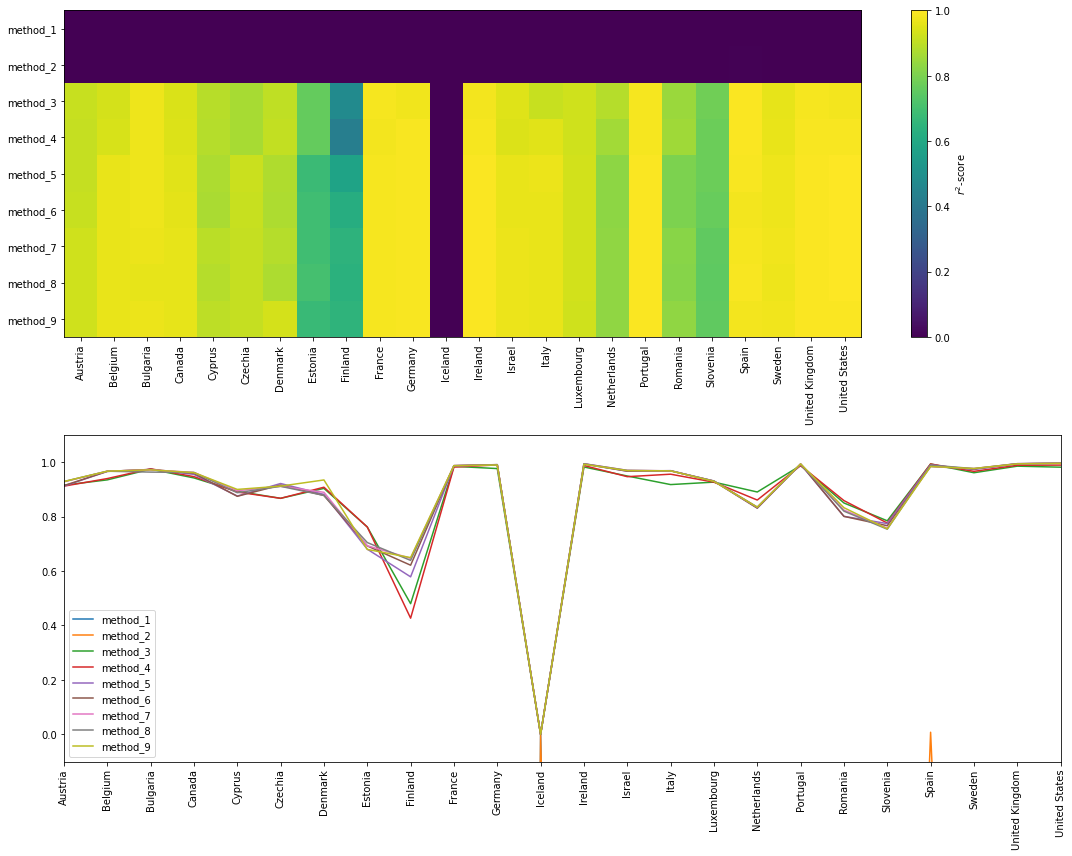

In [145]:
countries = total_df.location.unique()
feature_methods = [v for k, v in dict(globals()).items() if k.startswith("method_")]
feature_names = [
    v.__name__ for k, v in dict(globals()).items() if k.startswith("method_")
]
number_of_splits = 6

performance = np.zeros((len(countries), len(feature_methods)))

for i, country in enumerate(countries):
    for j, method in enumerate(feature_methods):
        df = method(total_df[total_df.location == country])
        X, y, X_validate, y_validate = prepare_training_data(df)
        model, _ = train_model(X, y, number_of_splits, LinearRegression())

        performance[i, j] = model.score(X_validate, y_validate).mean()

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15, 12))

# 2d plot
m = ax1.imshow(performance.T, aspect="auto", vmin=0.0, vmax=1.0)
ax1.set_xticks(range(len(countries)))
ax1.set_xticklabels(countries, rotation="vertical")
ax1.set_yticks(range(len(feature_names)))
ax1.set_yticklabels(feature_names)
cbar = plt.colorbar(m, ax=ax1)
cbar.set_label("$r^2$-score")

# lineouts
for i, perf in enumerate(performance.T):
    ax2.plot(perf, label=feature_names[i])

ax2.legend()
ax2.set_xlim(0, len(performance)-1)
ax2.set_xticks(range(len(countries)))
ax2.set_xticklabels(countries, rotation="vertical")
ax2.set_ylim(-0.1, 1.1)
fig.tight_layout()

For certain countries, like Iceland, forecasting the number of ICU patients is error prone. This is due to the fact, that Iceland did not had any patients in intensive care units and our model can not capture this. However we see that we have to include the ICU's from the previous days to properly forecast the number of ICU's. Features based on method 7 seem to perform best and will be the basis for the next steps.

## Forecasting ICU for Portugal

With the developed model, we can look into the situation in Portugal. An interesting aspect is to compare how the number of ICU would have developed if from a day in december the number of new cases stayed constant or if the number of new cases declined. This aspect is important to look at as it would allow to examine how good or bad the decision making in Portugal was.

- Don't do any feature Cross-validation (for now)

(0.0, 744.15)

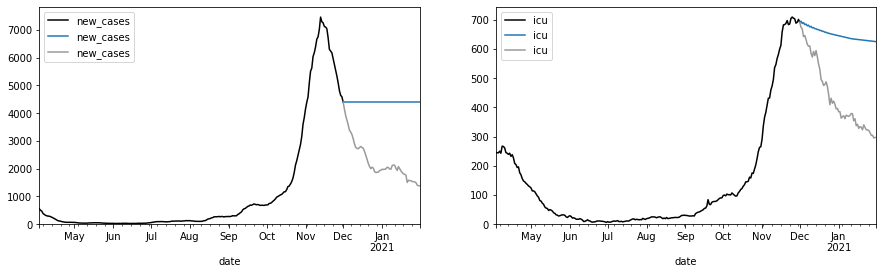

In [139]:
# portugal dataset
portugal_df = total_df.loc[total_df.location == "Austria", ["new_cases_smoothed", "icu_patients"]]
portugal_df = portugal_df.rename(columns={"new_cases_smoothed": "new_cases", "icu_patients": "icu"})
portugal_df["icu_yesterday"] = portugal_df["icu"].shift(1)
portugal_df["icu_yesterday_diff"] = portugal_df["icu_yesterday"].diff()
portugal_df = portugal_df.dropna().astype({"icu_yesterday": int, "icu_yesterday_diff": int})


# model
model = LinearRegression(normalize=True)
model.fit(portugal_df[["new_cases", "icu_yesterday", "icu_yesterday_diff"]], portugal_df[["icu"]])

# prediction
prediction_range = pd.date_range(start="2020-12-01", end=portugal_df.index[-1])
prediction_df = portugal_df.loc[prediction_range, :].copy()
prediction_df.loc[prediction_range[1:], "new_cases"] = prediction_df.loc[prediction_range[0], "new_cases"]
prediction_df = prediction_df.dropna().astype({"icu_yesterday": int, "icu_yesterday_diff": int})

for day in prediction_range[1:]:
    prev_day = day - day.freq
    X = prediction_df.loc[prev_day, ["new_cases", "icu_yesterday", "icu_yesterday_diff"]].to_numpy()
    icu = model.predict(X.reshape((1, 3)))
    prediction_df.loc[day, "icu"] = int(icu[0, 0])
    prediction_df.loc[day, "icu_yesterday"] = prediction_df.loc[prev_day, "icu"]
    prediction_df.loc[day, "icu_yesterday_diff"] = (
        prediction_df.loc[prev_day, "icu"]
        - prediction_df.loc[prev_day, "icu_yesterday"]
    )

## Create new plot
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 4))

## New cases
portugal_df[:prediction_range[0]].plot.line(y="new_cases", ax=ax1, color="k")
prediction_df.plot.line(y="new_cases", ax=ax1)
portugal_df[prediction_range[0]:].plot.line(y="new_cases", ax=ax1, color="0.6")

## ICU cases
portugal_df[:prediction_range[0]].plot.line(y="icu", ax=ax2, color="k")
prediction_df.plot.line(y="icu", ax=ax2)
portugal_df[prediction_range[0]:].plot.line(y="icu", ax=ax2, color="0.6")
ax1.set_ylim(ymin=0)
ax2.set_ylim(ymin=0)

In [124]:
@widgets.interact(
    country=widgets.Dropdown(
        options=total_df.location.unique(),
        description="Country",
    ),
    value=widgets.SelectionSlider(
        options=(2 / (1 + np.exp(-np.linspace(-5, 5, 1001)))),
        index=500,
        description="Growth",
    )
)
def print_value(country, value):
    print(country)

interactive(children=(Dropdown(description='Country', options=('Austria', 'Belgium', 'Bulgaria', 'Canada', 'Cy…